組員名單：  
108303067 會計一 杜淑萍   
105306019 資管四 陳宇鑫   
105308035 風管四 黃偉竣  
105308045 風管四 林庭萱  

該程式碼和其他相關檔案的github repository：    
https://github.com/SwordenBlade1230/NCCU_ComputerProgramming_groupProject

# 0. 前言

本程式碼包含三個部分，分別是資料蒐集、資料前處理和建立模型，每個段落的程式碼可以獨立執行。如果按照該程式碼的教學從頭到尾執行一遍，將會產出一個能夠辨識藝人的模型。但是過程中還是有一些部分需要人力介入，例如在擷取臉部圖片的步驟後必須人工篩選符合預期的圖片。

在執行該程式碼前，請確保和該程式碼同一個目錄下有**chromedriver.exe**和**haarcascade_frontalface_default.xml**的檔案(這兩個檔案可以直接從上方提供的github repository下載，網路上打關鍵字也有資源可以下載)，分別在之後爬取圖片和擷取圖片中的人臉時會用到。另外，有一個名為**說明圖片**的資料夾，裡面存放解說的圖片，如果移除或移動路徑將無法在該程式碼上看到相關的說明圖片，因此盡量不要動到它。

<img src="說明圖片/0_1.png">

# 1. 資料蒐集

## 1.1 取得明星列表

由於網路上並沒有華人50大男明星的參考列表，自己想又缺乏客觀依據，因此針對男明星的列表，我們以「網路溫度計 - 歌手天團 - 網路聲量 」為參考，取出熱度前200名的明星(目前以歌手和樂團主唱為主)。雖然排名在前面的明星有可能是因為負面聲量的關係，但這些明星能排名在前面至少近期討論度算高的。

In [1]:
# 安裝必要的函式庫
#!pip install beautifulsoup4

In [2]:
# 載入函式庫
import requests
from bs4 import BeautifulSoup
import time
import datetime

In [3]:
# 設定最多要爬到第幾頁的資料(一頁有十位明星的名稱)
max_page = 20

In [4]:
# 主程式
star_list = [] # 用來裝歌手和樂團的列表

st = time.time()

for pg in range(1, max_page + 1):
    res = requests.get('https://dailyview.tw/top100/topic/8?volumn=1&page=' + str(pg))
    soup = BeautifulSoup(res.text)
    for i in soup.find_all(class_ = "img-responsive"):
        star_list.append(i.get('alt'))
    time.sleep(3) # 每隔三秒再去抓下一頁的資料，避免一下子發送太多的request導致被目標網站當成機器人而被擋掉

ed = time.time()
spend_time = ed - st
print(f'花費時間：{spend_time:.2f}秒')

花費時間：73.20秒


In [6]:
# 印出前五名的結果
star_list[:5]

['羅志祥', '簡愷樂', '謝和弦', '黃偉晉', '蔡依林']

In [8]:
# 將列表存成記事本方便未來操作
today = datetime.date.today()
target_file_name = '網路溫度計 - 歌手天團 - 網路聲量 前兩百名的歌手及樂團名稱_' + str(today) + '.txt'

with open(target_file_name, 'w', encoding="utf-8") as f:
    for item in star_list:
        f.write("%s\n" % item)

執行完該部分的程式碼後，將會在和該程式碼同一個目錄下產生一個名為「網路溫度計 - 歌手天團 - 網路聲量 前兩百名的歌手及樂團名稱_當天日期」的文字檔，裡面將會有200位歌手和樂團的名稱，如下圖所示。

<img src="說明圖片/1.1_1.png">

因為我們只需要前50名男明星的名稱，因此需要對該文字檔做篩選(把女明星和排名比較後面的男明星篩選掉)，該程式碼之後將以前25名男明星為例(下方的範例圖片是2020-04-27的結果，現在排名應該會有所更動)。在篩選的過程中，如果遇到樂團名稱就以該樂團的主唱為主，例如「五月天」就改成「阿信 五月天」，而對於有些藝名在搜尋上較難辨識的明星而言，就把該明星的名字也一併附上，例如「小宇」改成「小宇 宋念宇」。篩選完之後將檔案另存為**明星列表.txt**，一樣是存放在和該程式碼同一個目錄下。

<img src="說明圖片/1.1_2.png">

## 1.2 爬取瀏覽器圖片(搜狗圖片)

原本我們打算用google_images_download從Google爬取圖片，但今年初在Google改變其前端的程式碼之後該函式就失效了，因此後來我們改寫網路一個爬取搜狗圖片的範例，作為我們蒐集圖片的主程式(參考來源有附在下方)。

注意事項：
* 在跑該部分的程式之前，必須確定ChromeDriver的執行檔放在和該程式碼同一個目錄下，然而該執行檔是Windows的版本，如果是用其他作業系統必須去網路下載和自己作業系統匹配的ChromeDriver執行檔。  
https://chromedriver.chromium.org/downloads
* 雖然有設置爬蟲的冷卻時間(目前設3秒，可以再設更高)，但還是有可能會被對面的伺服器擋掉，因此執行該部分的程式碼到一半斷掉時(例如被伺服器檔或網路突然斷訊)，可以將**明星列表.txt**已經跑完的明星名稱移除，然後在運行一次該部分的程式碼(不過在做這個步驟前請先備份原始的明星列表，避免之後發生意外)。
* 程式碼在跑的過程中，不要動到新開啟的Chrome視窗(視窗中有寫「受到自動測試軟體的控制」的那個)。
* 該部分的程式碼會運行比較長的時間(爬一位明星的250張照片大概要花上3到6分鐘不等)，請耐心等候，或是去做別的事情。

* 函式名稱：image_crawler

* 函式參考來源：   https://medium.com/%E4%BC%81%E9%B5%9D%E4%B9%9F%E6%87%82%E7%A8%8B%E5%BC%8F%E8%A8%AD%E8%A8%88/python%E7%88%AC%E8%9F%B2-python-selenium-%E8%87%AA%E5%8B%95%E5%8C%96%E7%88%AC%E5%8F%96%E5%A4%A7%E9%87%8F%E5%9C%96%E7%89%87-a35d3c89c6d1

* 函式作者：陳宇鑫
* 注意事項：
    * 必須先下載ChromeDriver的檔案(執行檔)，並放在和該程式碼同一個目錄下
    * 程式碼在跑的過程中，不要動到新開啟的Chrome視窗(受到自動測試軟體的控制的那個)
* 函式參數：
    * target_name：目標照片主題的名字
    * url：爬取頁面網址
    * img_num = 100：要爬取的照片數量
    * base_path = 'imgs'：儲存圖片的基本路徑
    * chromeDriver = 'chromedriver'：ChromeDriver檔案存放的路徑(預設是和該程式同一個目錄下)

In [ ]:
# 安裝必要的函式庫
# !pip install selenium
# !pip install opencc-python-reimplemented

In [3]:
# 主函式
from selenium import webdriver
import time
import urllib
import os

def image_crawler(target_name, url, img_num = 100, base_path = 'imgs', chromeDriver = 'chromedriver'):
    print('----------- ChromeDriver準備中 -----------')
    
    # 目標元素的xpath
    xpath = '//div[@id="imgid"]/ul/li/a/img'
    
    # 啟動chrome瀏覽器
    driver = webdriver.Chrome(chromeDriver) 

    # 最大化窗口，因為每一次爬取只能看到視窗内的圖片  
    driver.maximize_window()  

    # 紀錄下載過的圖片網址，避免重複下載  
    img_url_dic = {}  

    # 瀏覽器打開爬取頁面
    driver.get(url)  

    # 如果沒有存圖的資料夾，則自動創建
    local_path = os.path.join(base_path, target_name)
    if not os.path.exists(local_path):
            os.makedirs(local_path)
            print('----------- 建立新資料夾：' + local_path + ' -----------')

    # 模擬滾動視窗瀏覽更多圖片
    pos = 0  
    m = 0 # 圖片編號 
    
    print('----------- 開始爬取圖片 -----------')
    for i in range(100):  
        pos += i*500 # 每次下滾500  
        js = "document.documentElement.scrollTop=%d" % pos  
        driver.execute_script(js)  
        time.sleep(3) # 設定休息時間，避免過度爬取被網頁擋掉(爬蟲必備的小技巧)

        for element in driver.find_elements_by_xpath(xpath):

            img_url = element.get_attribute('src')

            # 保存圖片到指定路徑
            if img_url != None and not img_url in img_url_dic:
                img_url_dic[img_url] = ''  
                m += 1

                # 如果已經儲存一定數量的照片，提前結束該函式
                if m > img_num:
                    driver.close()
                    print('---------- 程式處理完成，一共取得' + str(img_num) + '張' + target_name + '的圖片 ----------')
                    return

                # print(img_url)
                ext = img_url.split('/')[-1]
                # print(ext)
                filename = str(m).zfill(3) + '.jpg' # zfill可以字串未滿的位數補0，例如001、002...099、100

                # 每保存10張照片印出進度
                if m % 10 == 0:
                    print('目前進度：正在保存', filename)

                # 保存圖片
                urllib.request.urlretrieve(img_url, os.path.join(local_path, filename))

    # 結束該函式
    driver.close()
    print('---------- 程式處理完成，一共取得' + str(img_num) + '張' + target_name + '的圖片 ----------')
    return

In [8]:
### 讀取明星列表 ###
with open('明星列表.txt', 'r', encoding="utf-8") as f:
    star_list = f.read().splitlines()
print(star_list) # 印出來看名單是否無誤

['黃明志', '周興哲', '林俊傑', '阿璞 八三夭', '伍佰&China Blue', '翁立友', '畢書盡Bii', '小鬼 黃鴻升', '炎亞綸', 'HipHopMan歐陽靖', 'PG One 王昊', '邱勝翊 王子', '陳奕迅', '小宇 宋念宇', '王力宏', '青峰 蘇打綠']


In [9]:
### 生成簡體版本的歌手名單，以便之後擷取藝人圖片搜尋結果的網址(針對搜狗圖片或其他大陸的瀏覽器) ###
from opencc import OpenCC
cc = OpenCC('t2s')
star_list_simplified = [cc.convert(star) for star in star_list]
print(star_list_simplified) # 印出來看名單是否無誤

['黄明志', '周兴哲', '林俊杰', '阿璞 八三夭', '伍佰&China Blue', '翁立友', '毕书尽Bii', '小鬼 黄鸿升', '炎亚纶', 'HipHopMan欧阳靖', 'PG One 王昊', '邱胜翊 王子', '陈奕迅', '小宇 宋念宇', '王力宏', '青峰 苏打绿']


In [11]:
### 主程式 ###
for idx, star_name in enumerate(star_list):
    st = time.time()
    
    # 目標照片主題的名字
    print('---------------------- 目前進度：' + star_name + ' ----------------------')
    target_name = star_name

    # 爬取頁面網址 
    url = 'https://pic.sogou.com/pics?query=' + star_list_simplified[idx]
    
    # 要爬取照片的數量
    img_num = 250

    # 儲存圖片的基本路徑
    base_path = 'imgs'

    # ChromeDriver檔案放的位置
    chromeDriver = 'chromedriver' # 預設是和該程式同一個目錄下
    
    image_crawler(target_name, url, img_num, base_path, chromeDriver)

    ed = time.time()
    spend_time = ed - st
    print(f'花費時間：{spend_time:.2f}秒')

---------------------- 目前進度：黃明志 ----------------------
----------- ChromeDriver準備中 -----------
----------- 建立新資料夾：imgs\黃明志 -----------
----------- 開始爬取圖片 -----------
目前進度：正在保存 010.jpg
目前進度：正在保存 020.jpg
目前進度：正在保存 030.jpg
目前進度：正在保存 040.jpg
目前進度：正在保存 050.jpg
目前進度：正在保存 060.jpg
目前進度：正在保存 070.jpg
目前進度：正在保存 080.jpg
目前進度：正在保存 090.jpg
目前進度：正在保存 100.jpg
目前進度：正在保存 110.jpg
目前進度：正在保存 120.jpg
目前進度：正在保存 130.jpg
目前進度：正在保存 140.jpg
目前進度：正在保存 150.jpg
目前進度：正在保存 160.jpg
目前進度：正在保存 170.jpg
目前進度：正在保存 180.jpg
目前進度：正在保存 190.jpg
目前進度：正在保存 200.jpg
目前進度：正在保存 210.jpg
目前進度：正在保存 220.jpg
目前進度：正在保存 230.jpg
目前進度：正在保存 240.jpg
目前進度：正在保存 250.jpg
---------- 程式處理完成，一共取得250張黃明志的圖片 ----------
花費時間：230.27秒
---------------------- 目前進度：周興哲 ----------------------
----------- ChromeDriver準備中 -----------
----------- 建立新資料夾：imgs\周興哲 -----------
----------- 開始爬取圖片 -----------
目前進度：正在保存 010.jpg
目前進度：正在保存 020.jpg
目前進度：正在保存 030.jpg
目前進度：正在保存 040.jpg
目前進度：正在保存 050.jpg
目前進度：正在保存 060.jpg
目前進度：正在保存 070.jpg
目前進度：正在保存 080.jpg
目前進度：正在保存 090.jpg

----------- 建立新資料夾：imgs\陳奕迅 -----------
----------- 開始爬取圖片 -----------
目前進度：正在保存 010.jpg
目前進度：正在保存 020.jpg
目前進度：正在保存 030.jpg
目前進度：正在保存 040.jpg
目前進度：正在保存 050.jpg
目前進度：正在保存 060.jpg
目前進度：正在保存 070.jpg
目前進度：正在保存 080.jpg
目前進度：正在保存 090.jpg
目前進度：正在保存 100.jpg
目前進度：正在保存 110.jpg
目前進度：正在保存 120.jpg
目前進度：正在保存 130.jpg
目前進度：正在保存 140.jpg
目前進度：正在保存 150.jpg
目前進度：正在保存 160.jpg
目前進度：正在保存 170.jpg
目前進度：正在保存 180.jpg
目前進度：正在保存 190.jpg
目前進度：正在保存 200.jpg
目前進度：正在保存 210.jpg
目前進度：正在保存 220.jpg
目前進度：正在保存 230.jpg
目前進度：正在保存 240.jpg
目前進度：正在保存 250.jpg
---------- 程式處理完成，一共取得250張陳奕迅的圖片 ----------
花費時間：203.46秒
---------------------- 目前進度：小宇 宋念宇 ----------------------
----------- ChromeDriver準備中 -----------
----------- 建立新資料夾：imgs\小宇 宋念宇 -----------
----------- 開始爬取圖片 -----------
目前進度：正在保存 010.jpg
目前進度：正在保存 020.jpg
目前進度：正在保存 030.jpg
目前進度：正在保存 040.jpg
目前進度：正在保存 050.jpg
目前進度：正在保存 060.jpg
目前進度：正在保存 070.jpg
目前進度：正在保存 080.jpg
目前進度：正在保存 090.jpg
目前進度：正在保存 100.jpg
目前進度：正在保存 110.jpg
目前進度：正在保存 120.jpg
目前進度：正在保存 130.jpg
目前進度：正在保存 140.jp

跑完該部分的程式碼後，將會在和該程式碼同一個目錄下看到名為**imgs**的資料夾，點開後裡面會有各個明星的照片資料夾(目前以各個明星的名稱作為資料夾名稱)，如下面的範例圖片所示。

<img src="說明圖片/1.2_1.png">

有些明星的圖片可能不滿自己設定的張數(例如下面的範例圖片，可以猜猜看是哪一位藝人)，其原因可能在於該明星在對岸的知名度還沒有起來，或是近期處於被對岸封殺的狀態(畢竟我們是用大陸的瀏覽器)，如果張數和目標張數真的差太多，可以換別的明星重跑一次該部分的程式碼。

<img src="說明圖片/1.2_2.png">

# 2. 資料前處理

## 2.1 擷取圖片中的人臉

由於在我們剛才爬下來的圖片當中，有些圖片的背景就占了圖片中很大的篇幅(如以下的圖片範例)，這對之後建立一個人臉辨識模型將帶來很大的雜訊，因此我們需要將這些圖片中人臉的部分擷取出來，作為之後我們的訓練資料。我們將透過opencv的臉部分類器達到擷取人臉的目的。  

face_cascade.detectMultiScale參數說明：
* ScaleFactor：每次搜尋方塊減少的比例
* minNeighbers：每個目標至少檢測到幾次以上，才可被認定是真數據。
* minSize：設定數據搜尋的最小尺寸，如 minSize=(40,40)

注意事項：
* 在該部分程式碼運行的過程中，某些圖片可能基於某種原因無法被opencv讀取(目前我不知道原因為何)，但應該是占整體的少數，因此可以直接忽略
* 如果覺得人臉辨識的結果比預期張數少了太多(例如原本有250張照片，結果最後只剩50張)，可以降低face_cascade.detectMultiScale中 scaleFactor和minNeighbers的數字放寬臉部判定的門檻(目前我把該參數設成face_segmentation函式的參數了，可以在執行face_segmentation的時候直接調整)，以目前預設的參數大概10分鐘內可以跑完。
* opencv的臉部分類器可以多重擷取照片中的人臉，因此原始照片中可以有多個人臉。

參考來源：  
https://medium.com/@yanweiliu/python%E5%BD%B1%E5%83%8F%E8%BE%A8%E8%AD%98%E7%AD%86%E8%A8%98-%E4%B8%80-%E4%BD%BF%E7%94%A8open-cv%E8%BE%A8%E8%AD%98%E5%9C%96%E7%89%87%E5%8F%8A%E5%BD%B1%E7%89%87%E4%B8%AD%E7%9A%84%E4%BA%BA%E8%87%89-527ef48f3a86

使用opencv無法讀取中文路徑的解決方法：  
https://www.zhihu.com/question/67157462/answer/251754530

In [1]:
# 安裝必要的函式庫
# !pip install opencv-python
# !pip install opencc-python-reimplemented

In [2]:
### 主函式 ###
%matplotlib inline
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np

def face_segmentation(imgs_base_path, scaleFactor=1.05, minNeighbors=3, minSize=(32, 32)):
    
    # 建立新的資料夾，用來存放只含人臉部分的照片
    target_base_path = imgs_base_path + '_face'
    if not os.path.exists(target_base_path):
            os.makedirs(target_base_path)
            print('----------- 建立新資料夾：' + target_base_path + ' -----------')
    
    
    # 載入分類器
    face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
    
    for category_file_name in os.listdir(imgs_base_path):
        print('---------------------- 目前程式處理的資料夾名稱：' + category_file_name + ' ----------------------')
        
        # 建立和該類別對應的目標資料夾，用來存放該類別只含人臉部分的照片
        target_category_path = os.path.join(target_base_path, category_file_name)
        if not os.path.exists(target_category_path):
                os.makedirs(target_category_path)
                print('----------- 建立新資料夾：' + target_category_path + ' -----------')

        # 對該類別資料夾中的每一張照片擷取人臉的部分並輸出成新的照片
        for img_name in os.listdir(os.path.join(imgs_base_path, category_file_name)):
            #img = cv2.imread(os.path.join(imgs_base_path, category_file_name, img_name)) # 讀取圖片
            img = cv2.imdecode(np.fromfile(os.path.join(imgs_base_path, category_file_name, img_name),dtype=np.uint8),-1)
                # 讀取圖片(路徑含有中文字的版本)
            
            try:
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # 轉成灰階圖片
                faces = face_cascade.detectMultiScale(
                    gray, scaleFactor=scaleFactor, minNeighbors=minNeighbors, minSize=minSize)
                for idx, (x, y, w, h) in enumerate(faces):
                    crop_img = img[y:y+h, x:x+w] # 裁切圖片
#                     cv2.imwrite(
#                         os.path.join(target_base_path, category_file_name, img_name[:3] + '_' + str(idx + 1) + '.jpg'), 
#                         crop_img
#                     ) # 保存圖片至目標路徑
                    cv2.imencode('.jpg', crop_img)[1].tofile(
                        os.path.join(target_base_path, category_file_name, img_name[:3] + '_' + str(idx + 1) + '.jpg')
                    ) # 保存圖片至目標路徑(路徑含有中文字的版本)
            except:
                print('無法讀取', os.path.join(imgs_base_path, category_file_name, img_name))


In [3]:
### 主程式 ###
import time
st = time.time()

face_segmentation(imgs_base_path='imgs', scaleFactor=1.05, minNeighbors=3, minSize=(32, 32))

ed = time.time()
spend_time = ed - st
print(f'花費時間：{spend_time:.2f}秒')

----------- 建立新資料夾：imgs_face -----------
---------------------- 目前程式處理的資料夾名稱：HipHopMan歐陽靖 ----------------------
----------- 建立新資料夾：imgs_face\HipHopMan歐陽靖 -----------
無法讀取 imgs\HipHopMan歐陽靖\052.jpg
無法讀取 imgs\HipHopMan歐陽靖\083.jpg
無法讀取 imgs\HipHopMan歐陽靖\163.jpg
無法讀取 imgs\HipHopMan歐陽靖\168.jpg
無法讀取 imgs\HipHopMan歐陽靖\198.jpg
無法讀取 imgs\HipHopMan歐陽靖\239.jpg
---------------------- 目前程式處理的資料夾名稱：PG One 王昊 ----------------------
----------- 建立新資料夾：imgs_face\PG One 王昊 -----------
無法讀取 imgs\PG One 王昊\076.jpg
無法讀取 imgs\PG One 王昊\083.jpg
無法讀取 imgs\PG One 王昊\175.jpg
無法讀取 imgs\PG One 王昊\197.jpg
---------------------- 目前程式處理的資料夾名稱：伍佰&China Blue ----------------------
----------- 建立新資料夾：imgs_face\伍佰&China Blue -----------
無法讀取 imgs\伍佰&China Blue\005.jpg
無法讀取 imgs\伍佰&China Blue\020.jpg
無法讀取 imgs\伍佰&China Blue\026.jpg
無法讀取 imgs\伍佰&China Blue\104.jpg
無法讀取 imgs\伍佰&China Blue\116.jpg
無法讀取 imgs\伍佰&China Blue\189.jpg
---------------------- 目前程式處理的資料夾名稱：周杰倫 ----------------------
----------- 建立新資料夾：imgs_face\周杰倫

運行完該部分的程式碼之後，將會在和該程式碼同一個目錄下看到名為**imgs_face**的資料夾，點開來後會有各個明星臉部偵測的結果(如以下的範例圖片)，然而擷取出來的臉部圖片可能會有以下狀況：
* 可能會有重複的照片
* 可能擷取到的人臉非完整的
* 可能會擷取到非人臉的部分
* 可能出現根本不是那位藝人的臉
* 可能擷取到的臉本身過於「崩壞
* 可能擷取到的臉太過於「側面」

因此這部分需要**人力的介入**，對各個資料夾中的圖片進行人工篩選(強烈建議實施該步驟之前先將imgs_face的資料夾進行備份)，直到符合該明星的臉部照片至少超過規定的數量(我們目前以150張臉部照片為底線)。如果該明星的照片不足150張，可以透過Goole圖片、臉書、IG和微博等各種管道用截圖的方式補足(Windows作業系統可以用Win+Shift+S進行特定螢幕區域的截圖)。

<img src="說明圖片/2.1_1.png">

<img src="說明圖片/2.1_2.png">

## 2.2 將資料集整理成模型輸入的形式

現在我們已經有了特定明星的臉部資料集，之後將透過該部分的程式碼將其轉成之後方便模型輸入的形式(X_train, X_test, y_train, y_test)。

參考來源：https://pythonprogramming.net/loading-custom-data-deep-learning-python-tensorflow-keras/

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm # 進度條

In [2]:
DATADIR = "imgs_face"
IMG_SIZE = 64

In [3]:
CATEGORIES = os.listdir(DATADIR)
print(CATEGORIES) # 印出所有圖片的類別

['HipHopMan歐陽靖', 'PG One 王昊', '伍佰&China Blue', '周杰倫', '周興哲', '婁峻碩', '小宇 宋念宇', '小鬼 黃鴻升', '林俊傑', '炎亞綸', '王力宏', '畢書盡Bii', '羅志祥', '翁立友', '蕭敬騰', '謝和弦', '邱勝翊 王子', '邱鋒澤', '阿信 五月天', '阿璞 八三夭', '陳奕迅', '陳零九', '青峰 蘇打綠', '黃偉晉', '黃明志']


In [11]:
training_data = []

def create_training_data():
    for category in CATEGORIES:  # do dogs and cats

        path = os.path.join(DATADIR,category)  # create path to dogs and cats
        class_num = CATEGORIES.index(category)  # get the classification

        for img in tqdm(os.listdir(path)):  # iterate over each image per dogs and cats
            try:
                #img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
                #img_array = cv2.imread(os.path.join(path,img))
                img_array = cv2.imdecode(np.fromfile(os.path.join(path,img),dtype=np.uint8),-1)
                # 讀取圖片(路徑含有中文字的版本)
                img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to normalize data size
                training_data.append([new_array, class_num])  # add this to our training_data
            except Exception as e:  # in the interest in keeping the output clean...
                pass

create_training_data()

100%|██████████████████████████████████████████████████████████████████████████████| 245/245 [00:00<00:00, 2670.19it/s]


In [12]:
X = []
y = []

for features,label in training_data:
    X.append(features)
    y.append(label)

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3) # 彩色圖片的cahnnel數為3

In [28]:
# 將資料集隨機切分成訓練集和測試集
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
print(x_train.shape)
print(len(y_train))
print(x_test.shape)
print(len(y_test))

(4565, 64, 64, 3)
4565
(1957, 64, 64, 3)
1957


In [29]:
# 將處理完後的結果輸出，方便未來調用
import pickle

pickle_out = open("x_train.pickle","wb")
pickle.dump(x_train, pickle_out)
pickle_out.close()

pickle_out = open("y_train.pickle","wb")
pickle.dump(y_train, pickle_out)
pickle_out.close()

pickle_out = open("x_test.pickle","wb")
pickle.dump(x_test, pickle_out)
pickle_out.close()

pickle_out = open("y_test.pickle","wb")
pickle.dump(y_test, pickle_out)
pickle_out.close()

pickle_out = open("class_names.pickle","wb")
pickle.dump(CATEGORIES, pickle_out)
pickle_out.close()

# 3. 建立模型

In [30]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

### 1. 讀入之前經過處理的明星數據集

In [31]:
# 讀取之前經過處理後的X和y，以及類別的名稱
pickle_in = open("X_train.pickle","rb")
x_train = pickle.load(pickle_in)

pickle_in = open("y_train.pickle","rb")
y_train = pickle.load(pickle_in)

pickle_in = open("X_test.pickle","rb")
x_test = pickle.load(pickle_in)

pickle_in = open("y_test.pickle","rb")
y_test = pickle.load(pickle_in)

pickle_in = open("class_names.pickle","rb")
class_names = pickle.load(pickle_in)

### 2. 欣賞數據集內容

<Figure size 432x432 with 0 Axes>

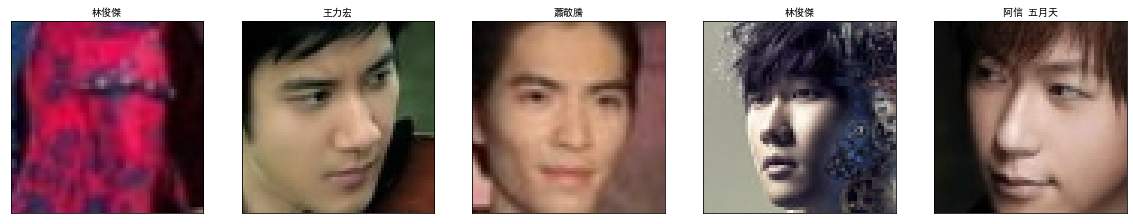

In [44]:
# plt相關參數設定
plt.rcParams['font.sans-serif'] = ['simhei'] # 可以顯示中文字體
plt.rcParams['axes.unicode_minus'] = False # 可以正常顯示負號
plt.figure(figsize=(6,6)) # 畫布大小

# 隨機看訓練集中的5筆資料
pick = np.random.choice(x_train.shape[0], 5, replace=False)
plt.figure(figsize=(20,10)) # 調整畫布的大小

for i in range(5):
    n = pick[i]
    ax = plt.subplot(151+i)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(class_names[y_train[n]], fontsize=10)
    plt.imshow(x_train[n], cmap='Greys') 

從上圖談人工篩選圖片的重要性...

### 3. 資料前處理(針對模型的前處理)

In [45]:
### 資料前處理 ###

# 圖片像素正規化
x_train = x_train / 255
x_test = x_test / 255

# 標籤獨熱編碼
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, len(class_names))
y_test = to_categorical(y_test, len(class_names))

### ---------- 目前可以一路執行程式碼到這裡為止，神經網路的架構之後要再商榷 -----------

### 4. 打造神經網路(VGG19 & ResNet50)
這邊要注意由於我們是用彩色圖片下去訓練，channel要設成3。

In [ ]:
### 設定模型架構 ###
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense # dense：全連結神經層
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout # CNN會用到的layer
    # Conv2D的2D代表每個「記分板(kernal)」的維度 
    # 如果輸入的是2D圖片(無論是灰階或是彩色)都是用Conv2D，輸入的是3D的立體圖片用Conv3D
    # Conv2D輸入的是三維數據(width, height, channels)；Conv3D輸入的是四維數據(width, height, depth, channels)
from tensorflow.keras.layers import Dense, Flatten # dense = 全連結神經層
import keras

model = Sequential() # 打開一個空白的函數學習機

# Conv block 1
model.add(Conv2D(16, (3,3), padding = 'same', input_shape = (x_train.shape[1],x_train.shape[2],3), activation = 'relu')) 
    # padding = 'same': 輸入的維度是多少，無論filter的大小，輸出的維度就是多少
model.add(Conv2D(16, (3,3), padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

# Conv block 2
model.add(Conv2D(32, (3,3), padding = 'same', activation = 'relu'))
model.add(Conv2D(32, (3,3), padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

# Conv block 3
model.add(Conv2D(64, (3,3), padding = 'same', activation = 'relu'))
model.add(Conv2D(64, (3,3), padding = 'same', activation = 'relu'))
model.add(Conv2D(64, (3,3), padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

# Conv block 4
model.add(Conv2D(128, (3,3), padding = 'same', activation = 'relu'))
model.add(Conv2D(128, (3,3), padding = 'same', activation = 'relu'))
model.add(Conv2D(128, (3,3), padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

# Conv block 5
model.add(Conv2D(128, (3,3), padding = 'same', activation = 'relu'))
model.add(Conv2D(128, (3,3), padding = 'same', activation = 'relu'))
model.add(Conv2D(128, (3,3), padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

# fully-connected classifier
model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.25)) # 在全連結層後面加上dropout layer可以減少模型overfitting的現象
model.add(Dense(len(class_names), activation = 'softmax'))

model.compile(loss = keras.losses.categorical_crossentropy, optimizer = 'adam', metrics = ['accuracy'])


**查看模型結構**

In [ ]:
model.summary()

**實施early stopping，即模型訓練一段時間之後，當準確率不再有顯著的提升就提早結束訓練，這樣不僅能夠節省訓練的時間，也可以防止模型過度擬合。**

In [ ]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 3, verbose = 0, mode = 'auto') 
    # patience = 3: 當模型不再有顯著的進步時，還會再多訓練3個epochs才結束訓練

### 5. 訓練模型

**這裡我用訓練集中三成的資料做為驗證集**

In [ ]:
history = model.fit(x_train, y_train, batch_size = 128, epochs = 20, validation_split = 0.3, callbacks = [early_stopping])

### 6. 訓練成果

**查看該模型預測測試集資料的結果**

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

**查看該模型預測測試集資料的結果**

In [ ]:
score = model.evaluate(x_test, y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

**用互動模式看模型預測測試集某一張圖片的結果**

In [ ]:
result = model.predict_classes(x_test)

In [ ]:
def my_predict(n):
    print('我的模型預測是', class_names[result[n]])
    print('實際的標籤是', class_names[np.argmax(y_test[n])])
    X = x_test[n].reshape(64,64)
    plt.imshow(X, cmap = 'Greys')

In [ ]:
from ipywidgets import interact_manual
interact_manual(my_predict, n = (0, 9999)) # (要互動的函數, 輸入的範圍)

**將訓練完的模型和權重儲存起來**

In [ ]:
model.save('myModel.h5')

In [ ]:
model_json = model.to_json()
open('myModel_architecture.json', 'w').write(model_json)
model.save_weights('myModel_weights.h5')